In [103]:
import numpy
import corner
import emcee
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import scipy.optimize
import sys
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
import scipy.optimize as op
from astropy.constants import c
import functions_polarization_MCMC as mcmc
import function_plots as mcmc_plots
from importlib import reload

In [90]:
# Importing data:
path_git = r'/net/vdesk/data2/GoesaertW/Data_Analyis_Git/'
rsl = fits.open(get_pkg_data_filename(path_git+'Abell85_catalog_BDSF_rsl.fits'))[1].data

path_rmsynth = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/rmsynth/'
fname_polint = 'rmsynth_polint'
hdu_polint = fits.open(get_pkg_data_filename(path_rmsynth+fname_polint+'.fits'))[0]
del hdu_polint.header['CROTA4']
data_polint = hdu_polint.data
wcs = WCS(hdu_polint.header)

savedir =r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Photometry_BDSF/'

freqs = np.load('MKT_Freqs_mid.npy')
lamb = c.value/freqs

flux_measurements_I = np.load(savedir+'Abell85_BDSF_I.npy')
flux_measurements_Q = np.load(savedir+'Abell85_BDSF_Q.npy')
flux_measurements_U = np.load(savedir+'Abell85_BDSF_U.npy')
flux_unc_I = np.load(savedir+'Abell85_BDSF_unc_I.npy')
flux_unc_Q = np.load(savedir+'Abell85_BDSF_unc_Q.npy')
flux_unc_U = np.load(savedir+'Abell85_BDSF_unc_U.npy')
sources_phi = np.load(savedir+'Abell85_phi.npy')
mask = np.load(savedir+'Abell85_mask_pointsigma.npy')

I_select = flux_measurements_I[:,mask]
Q_select = flux_measurements_Q[:,mask]
U_select = flux_measurements_U[:,mask]
I_unc_select = flux_unc_I[:,mask]
Q_unc_select = flux_unc_Q[:,mask]
U_unc_select = flux_unc_U[:,mask]
phi_select = sources_phi[mask]
rsl_select = rsl[mask]

angles = 0.5*np.arctan(U_select/Q_select)
linpol = np.sqrt(U_select**2 + Q_select**2)

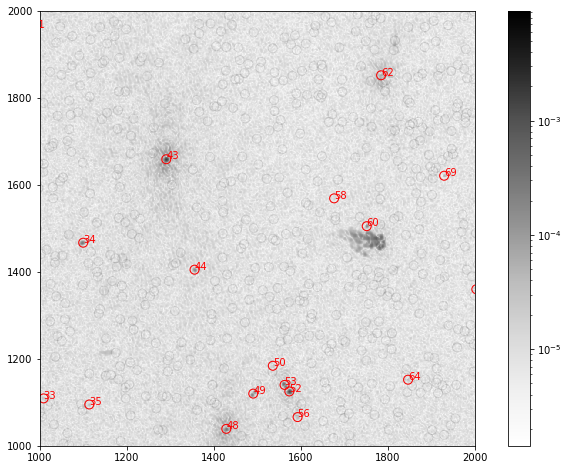

In [47]:
# Selecting the five sources that Erik Osinga also investigated as check:
sources_worldpos = np.array((rsl['RA'], rsl['DEC']))
sources_pixpos_floats = wcs.all_world2pix(rsl['RA'], rsl['DEC'], 0)
sources_pixpos = np.swapaxes(np.rint(sources_pixpos_floats\
                                     , out=np.zeros(np.shape(sources_worldpos)
                                     , int), casting='unsafe'),0,1)
plt.figure(figsize=(12,8))
a = plt.imshow(data_polint.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.scatter(sources_pixpos[:,0], sources_pixpos[:,1], s=80, facecolors='none', edgecolors='black', alpha=0.1)
plt.scatter(sources_pixpos[mask,0], sources_pixpos[mask,1], s=80, facecolors='none', edgecolors='r')
for n in range(len(sources_pixpos[mask,0])):
    plt.text(sources_pixpos[mask,0][n], sources_pixpos[mask,1][n], str(n), color='red', clip_on=True)
plt.colorbar(a)
plt.xlim(1000,2000)
plt.ylim(1000,2000)
plt.show()

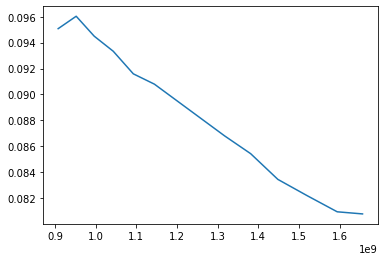

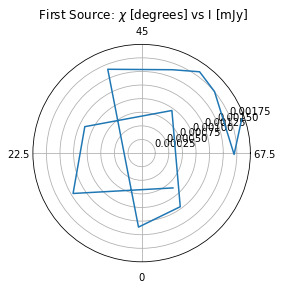

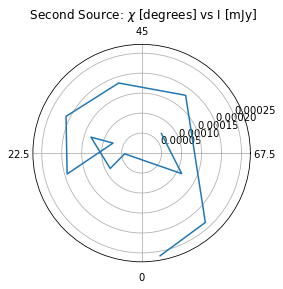

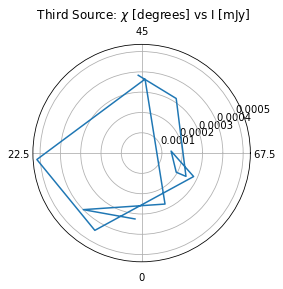

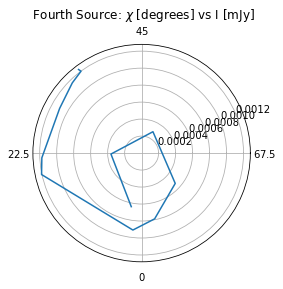

In [83]:
plt.plot(freqs, I_select[:,43])
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles[:,43], linpol[:,43])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" First Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles[:,44], linpol[:,44])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Second Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles[:,53], linpol[:,53])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Third Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*angles[:,52], linpol[:,52])
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Fourth Source: $\chi$ [degrees] vs I [mJy]")
plt.show()

In [91]:
#So, we need the sources 43, 44, 53, 54:
mask_erik = np.zeros(len(I_select[0]), dtype=bool)
mask_erik[43]=True
mask_erik[44]=True
mask_erik[53]=True
mask_erik[54]=True
I_compar = I_select[:,mask_erik]
Q_compar = Q_select[:,mask_erik]
U_compar = U_select[:,mask_erik]
I_unc_compar = I_unc_select[:,mask_erik]
Q_unc_compar = Q_unc_select[:,mask_erik]
U_unc_compar = U_unc_select[:,mask_erik]
phi_compar = phi_select[mask_erik]
rsl_compar = rsl_select[mask_erik]

angles_compar = 0.5*np.arctan(U_compar/Q_compar)
linpol_compar = np.sqrt(U_compar**2 + Q_compar**2)

# Using Faraday MCMC functions script:

Saving chain to /net/vdesk/data2/GoesaertW/Meerkat_Data/Achain_source_0_QU.npy


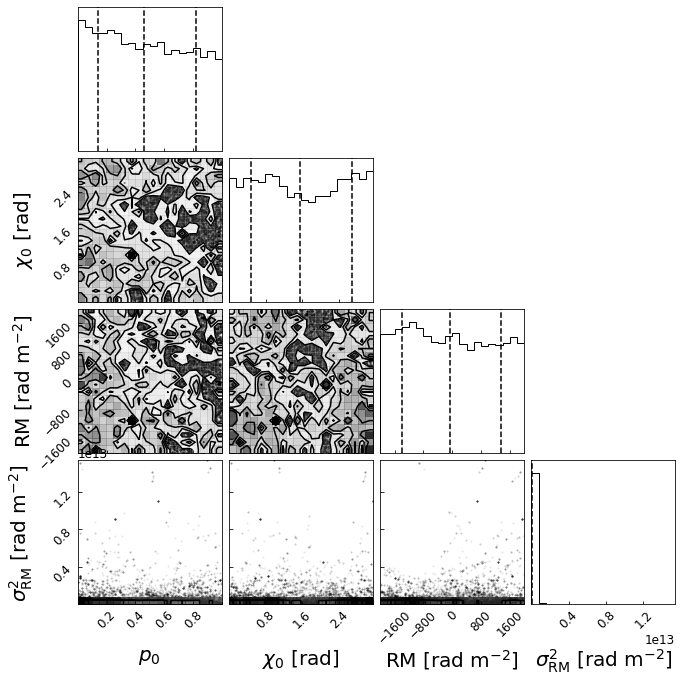

In [107]:
reload(mcmc)
reload(mcmc_plots)
#We will look at the last of the 4 sources:
source=3
fit_dataI, fit_data, x, y = mcmc.polarization_fitting(lamb**2, I_compar[:,source], I_unc_compar[:,source]\
                        , Q_compar[:,source], Q_unc_compar[:,source], U_compar[:,source], U_unc_compar[:,source]\
                        , phi_compar[source], rsl_compar[source]['RA'], rsl_compar[source]['DEC'], cornerplot=True,curvature=True\
                        ,sourcenum=0)

plots.plots(depol, 'depolfit_test', lamb**2, fit_dataI[0], fit_dataI[1], fit_dataI[2], fit_data[0], fit_data[1], fit_data[2], fit_data[3], I_compar[:,source], I_unc_compar[:,source]\
                        , Q_compar[:,source], Q_unc_compar[:,source], U_compar[:,source], U_unc_compar[:,source]\
                        , y_X, err_X, y_p, err_p, xlim=[0.005, 0.06], imgformat="pdf",saveplot=False)

In [109]:
print(fit_data)

[['p0', 0.46268047911249316, -0.3268606741848494, 0.36050206743510654], ['chi0', 1.54565411751916, -1.0641821415798063, 1.140634797496539], ['RM', -73.67759898626954, -1321.2450192227984, 1422.9060039354065], ['sigma', 22342426.020882525, -22317287.470551662, 12298599788.337934]]


# Classic Chisquared Method:

In [ ]:
#The depolarization model:
def model_p(lambsqw, p0, chi0, RM, chiRMsq):
    return p0*np.exp(-2*((chiRMsq*lambsqw)**2))*np.exp(2j*(chi0+RM*lambsqw))

#A function which calculates the chi_sqw for array of values
def chi_squared(I_data, v_data_error, v_model):
    deviations = ((v_data - v_model)/v_data_error)**2
    return np.sum(deviations)

#Minimize takes all data and parameters and calculates chisqw, this should be minimized
def minimize(p, f, v_data, v_data_error, time):
    f0, v0, k = p
    v_model = model(time, f0, f, v0, k)
    return chi_squared(v_data, v_data_error, v_model)

In [ ]:
#We are going to look at fourth source because very nice rotation:
n=3

#Values which were guessed are implemented in the parameter grid:
p0_guess, p0_var = 0.5, 0.5 # 50 total
chi0_guess, chi0_var = np.pi/2, np.pi/2 # 78 total
RM_guess, RM_var = phi_compar[n], 20 # 40 total
chiRM_guess, chiRM_var = 30, 30 # 60 total

#Parametergrid is defined:
ranges = (slice(p0_guess-p0_var, p0_guess+p0_var, 0.02), slice(chi0_guess-chi0_var, chi0_guess+chi0_var, 0.04)\
          , slice(RM_guess-RM_var, RM_guess+RM_var, 1))
depol_range = np.arange(chiRM_guess-chiRM_var, chiRM_guess+chiRM_var, 2)

#Parameter array and chisqw arrays are defined to be filled later:
theta_array = np.zeros((len(depol_range), 3))
chisqw_array = np.zeros((len(depol_range)))

#A brute fit is performed for each period. Brute takes grid with function to be minimized
#and outputs the gridpoint with the lowest associated value:
for n,depol in enumerate(depol_range):
    resbrute  = op.brute(minimize, ranges, args=(depol, radial_vel.value, radial_vel_error.value, time.value), full_output=1,finish=None)
    theta_array[n] = resbrute[0]
    chisqw_array[n] = resbrute[1]

#Output is saved in variables:
best = np.argmin(chisqw_array)
p0, chi0, RM = theta_array[best]
chiRMsq = depol_range[best]
chisqw = chisqw_array[best]

# Markov Chain Monte Carlo section:

In [ ]:
ndim, nwalkers = 4, 500 #dimensionnumber and walker number are defined

guess = np.array([p0, chi0, RM, chiRMsq]) #As guess, output of refined brute fit is used
guess_error = np.array([f0_var_2, f_var_2, v0_var_2, k_var_2]) #And as error, the input grid width of refined brute fit